In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!python setup.py develop

running develop
running egg_info
writing pylib.egg-info/PKG-INFO
writing dependency_links to pylib.egg-info/dependency_links.txt
writing top-level names to pylib.egg-info/top_level.txt
reading manifest file 'pylib.egg-info/SOURCES.txt'
writing manifest file 'pylib.egg-info/SOURCES.txt'
running build_ext
Creating /store17/petrov/anaconda3/lib/python3.7/site-packages/pylib.egg-link (link to .)
pylib 0.1 is already the active version in easy-install.pth

Installed /spoolA/petrov/refac20/notebooks
Processing dependencies for pylib==0.1
Finished processing dependencies for pylib==0.1


In [3]:
import pylib.preprocess_data.kskl as kskl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('pylib/cmd1202.mplstyle')

In [4]:
SEASON = 'HIGH11'
df_total_info = kskl.season_csv_table(SEASON)
df_total_info.head()

,elabel,lum_exp,lum_exp_err,mlt_raw,mc_tree_kskl_mcgpj,exp_tree,mc_tree_kskl_uniform,emeas
0,525_8997,495.393,0.990654,/store17/petrov/data/kskl20/tr_ph/multi/11/tr_...,/store17/petrov/data/kskl20/tr_ph/11/tr_ph_ksk...,root://sl10cmd//scan2011/scan2011_tr_ph_fc_e52...,/store17/petrov/data/kskl_uniform_individual/1...,523.580017
1,550_9158,501.106,1.068890,/store17/petrov/data/kskl20/tr_ph/multi/11/tr_...,/store17/petrov/data/kskl20/tr_ph/11/tr_ph_ksk...,root://sl10cmd//scan2011/scan2011_tr_ph_fc_e55...,/store17/petrov/data/kskl_uniform_individual/1...,548.440002
2,575_9288,497.088,1.115680,/store17/petrov/data/kskl20/tr_ph/multi/11/tr_...,/store17/petrov/data/kskl20/tr_ph/11/tr_ph_ksk...,root://sl10cmd//scan2011/scan2011_tr_ph_fc_e57...,/store17/petrov/data/kskl_uniform_individual/1...,575.309998
3,600_9407,560.623,1.231000,/store17/petrov/data/kskl20/tr_ph/multi/11/tr_...,/store17/petrov/data/kskl20/tr_ph/11/tr_ph_ksk...,root://sl10cmd//scan2011/scan2011_tr_ph_fc_e60...,/store17/petrov/data/kskl_uniform_individual/1...,598.036987
4,625_9475,412.970,1.101960,/store17/petrov/data/kskl20/tr_ph/multi/11/tr_...,/store17/petrov/data/kskl20/tr_ph/11/tr_ph_ksk...,root://sl10cmd//scan2011/scan2011_tr_ph_fc_e62...,/store17/petrov/data/kskl_uniform_individual/1...,622.469971


In [15]:
# import uproot
# from tqdm import tqdm
# for i, row in tqdm(df_total_info.iterrows()):
#     tr_ph = uproot.open(row['exp_tree'])['tr_ph']
#     df_total_info.at[i, 'emeas'] = tr_ph['emeas'].array(entry_stop=10)[0]
# df_total_info['mlt_raw'] = '/store17/petrov/data/kskl20/tr_ph/multi/11/tr_ph_run0' + df_total_info['mlt_raw'].astype(str) + '.root'

In [24]:
# df_total_info.to_csv('data/HIGH11.csv', index=False)

In [601]:
from tqdm import tqdm
SEASON = 'HIGH11'
def process_season(df_total_info):
    for i, row in tqdm(df_total_info.iterrows()):
        if i<18:
            continue
        elabel = row['elabel']
        print(elabel)
        ebeam = row['emeas']

        try:
            tr_ph = kskl.open_tree(row['exp_tree'])
            tr_ph_mc = kskl.open_tree(row['mc_tree_kskl_mcgpj'])
            tr_ph_mlt = kskl.open_tree(row['mlt_raw'])
        except ValueError:
            continue
        except FileNotFoundError:
            print(f'File {elabel} is not found')
            continue

        df = kskl.selection_df(tr_ph, finalstate_id=False, trigbits=True, remove_badruns=True)
        df.to_csv(f'../csv/{SEASON}/exp_tree/{elabel}.csv', float_format='%.4f', index=False)
        del df

        df_mc = kskl.selection_df(tr_ph_mc, finalstate_id=True)
        df_mc.to_csv(f'../csv/{SEASON}/mc_tree_kskl_mcgpj/{elabel}.csv', float_format='%.4f', index=False)
        del df_mc

        df_mlt = kskl.selection_df(tr_ph_mlt, finalstate_id=True)
        df_mlt.to_csv(f'../csv/{SEASON}/mlt_raw/{elabel}.csv', float_format='%.4f', index=False)
        del df_mlt
#         break
# process_season(df_total_info)

## Process points

In [6]:
idx = 0
elabel = df_total_info.at[idx, 'elabel']
ebeam = df_total_info.at[idx, 'emeas']
df_total_info.loc[idx]

elabel                                                           525_8997
lum_exp                                                           495.393
lum_exp_err                                                      0.990654
mlt_raw                 /store17/petrov/data/kskl20/tr_ph/multi/11/tr_...
mc_tree_kskl_mcgpj      /store17/petrov/data/kskl20/tr_ph/11/tr_ph_ksk...
exp_tree                root://sl10cmd//scan2011/scan2011_tr_ph_fc_e52...
mc_tree_kskl_uniform    /store17/petrov/data/kskl_uniform_individual/1...
emeas                                                          523.580017
Name: 0, dtype: object

In [7]:
def two_body_mask(df, eband):
    mask = kskl.cut_two_body_decay_angle(df.kspipt0, df.ksdpsi, ebeam_band=eband)
    mask = kskl.cut_two_body_decay_angle(df.kspipt1, df.ksdpsi, ebeam_band=eband)&mask
    return mask

from pylib.preprocess_data.kskl import get_x
def point_cut(df, ebeam: float):
    dfq = df.query('ksalign>0.8').copy()
    
    eband = (max(0.93*ebeam, 525), 1.07*ebeam)
    mask = two_body_mask(dfq, eband)
    dfq = dfq[mask]
    
    x1, x2 = get_x(dfq.ksminv, dfq.ksptot, ebeam)
    dfq = dfq.assign(x1=x1, x2=x2)
    return dfq


def process_point(df_total_info, idx: int, return_raw: bool = False, plot_cuts: bool = False) -> list:
    mPc = 139.6
    elabel = df_total_info.at[idx, 'elabel']
    ebeam = df_total_info.at[idx, 'emeas']
    print(f'Elabel: {elabel}')
    
    df = pd.read_csv(f'../csv/{SEASON}/exp_tree/{elabel}.csv')
    df_mc = pd.read_csv(f'../csv/{SEASON}/mc_tree_kskl_mcgpj/{elabel}.csv')
    df_mlt = pd.read_csv(f'../csv/{SEASON}/mlt_raw/{elabel}.csv')
    if return_raw:
        return [ebeam, df, df_mc, df_mlt]
    
    dfq = point_cut(df, ebeam)
    df_mcq = point_cut(df_mc, ebeam)
    df_mltq = point_cut(df_mlt, ebeam)
    
    return [ebeam, dfq, df_mcq, df_mltq]

In [8]:
fit_df = pd.DataFrame()

Cycle

In [9]:
import pylib.fit as pyfit
import pylib.style as pys
import iminuit

In [10]:
it = df_total_info.iterrows()

--------

In [449]:
idx, row = next(it)
elabel = row['elabel']
ebeam, dfq, df_mcq, df_mltq = process_point(df_total_info, idx, return_raw=False)

StopIteration: 

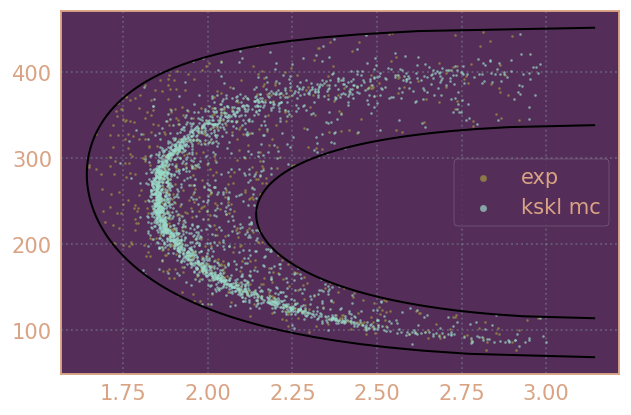

In [428]:
eband = (max(0.93*ebeam, 525), 1.07*ebeam)

momp, angp = kskl.two_body_decay_angle(eband[0], 100)
momm, angm = kskl.two_body_decay_angle(eband[1], 100)

plt.scatter(dfq.ksdpsi, dfq.kspipt1, s=7, label='exp')
plt.scatter(df_mcq.ksdpsi, df_mcq.kspipt1, s=7, alpha=0.7, label='kskl mc')
plt.legend()
plt.plot(angp, momp, color='black')
plt.plot(angm, momm, color='black')
# plt.xlim(None, 2)

In [429]:
fit_range_bkg = (-25, 25)
fit2poly = pyfit.FitPoly2(fit_range_bkg)

In [430]:
f = pyfit.Fitter(df_mltq.query('finalstate_id!=8').x1, fit2poly, dict(n_sig=0, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=580, b=1, c=0),
            fit_range=fit_range_bkg, lims=dict(n_sig=(0,0), m=(0, 0), sL=(1,1), sR=(1, 1), 
            aL=(1,1), aR=(1,1), n_bkg=(0, None), b=(None, None), c=(None, None)) )
f.fit()

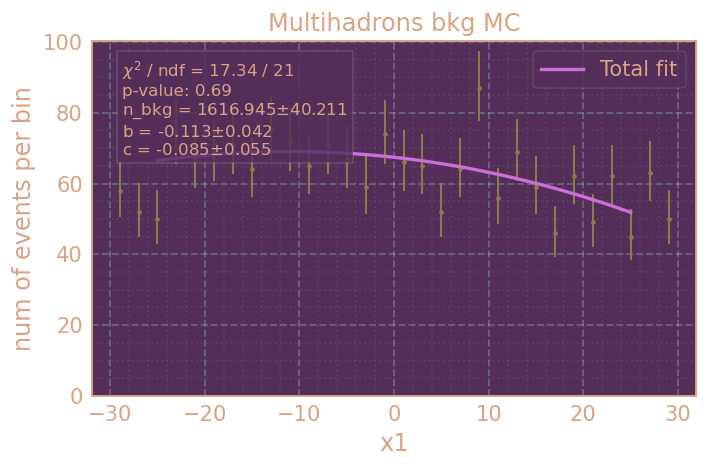

In [431]:
f.plot((-30, 30), bins=30, title='Multihadrons bkg MC', xtitle='x1', ytitle='num of events per bin', lw=2, 
        alpha=1, plot_bkg=False, fit_color='#CC6FD9', data_color='#8C7B48', bbox_color='#542D59', print_fixed_vals=False);

In [432]:
fit2poly = pyfit.FitPoly2(fit_range_bkg)
fmc = pyfit.Fitter(df_mcq.x1, fit2poly, dict(n_sig=len(df_mcq.x1), m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=0, b=0, c=0),
            fit_range=fit_range_bkg, lims=f.get_limits(n_sigmas=0, include=['b', 'c'], 
            my_lims=dict(n_sig=(0, None), m=(-20, 20), sL=(0.1, None), sR=(0.1, None), aL=(0, None), aR=(0, None), n_bkg=(0, 0))) )
fmc.fit()

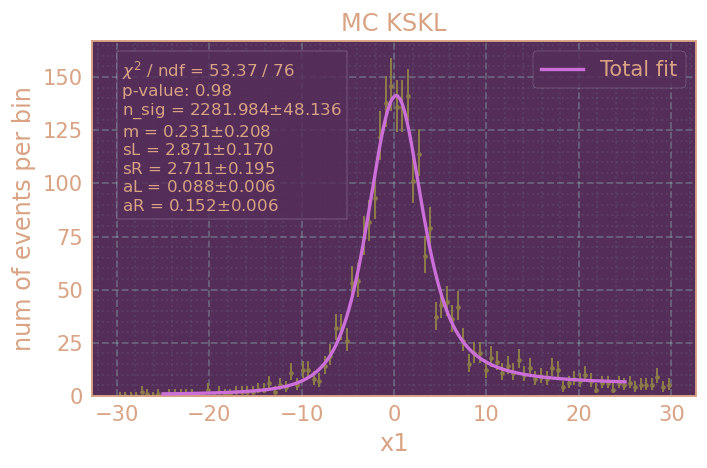

In [433]:
hist_rng, bins = (-30, 30), 100
fmc.plot(hist_rng, bins=bins, title='MC KSKL', xtitle='x1', ytitle='num of events per bin', lw=2, 
        alpha=1, fit_color='#CC6FD9', data_color='#8C7B48', bbox_color='#542D59', print_fixed_vals=False);

In [439]:
lims_mc = fmc.get_limits(n_sigmas=3, include=['sR', 'sL', 'aL', 'aR'])#, 'm'])
lims_mc['n_bkg'] = (0, None)
lims_mc['b'] = (f.get_params()['b'], f.get_params()['b'])
lims_mc['c'] = (f.get_params()['c'], f.get_params()['c'])

In [440]:
pars_mc = fmc.get_params()
pars_mc['n_bkg'] = 100

In [441]:
f2 = pyfit.Fitter(dfq.x1, fit2poly, pars_mc,#dict(n_sig=100, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=100, b=1, c=0),
            fit_range=fit_range_bkg, lims=lims_mc, sigmas=fmc.get_sigmas(exclude=['n_sig', 'n_bkg',  'b', 'c', 'm']) )
f2.fit()

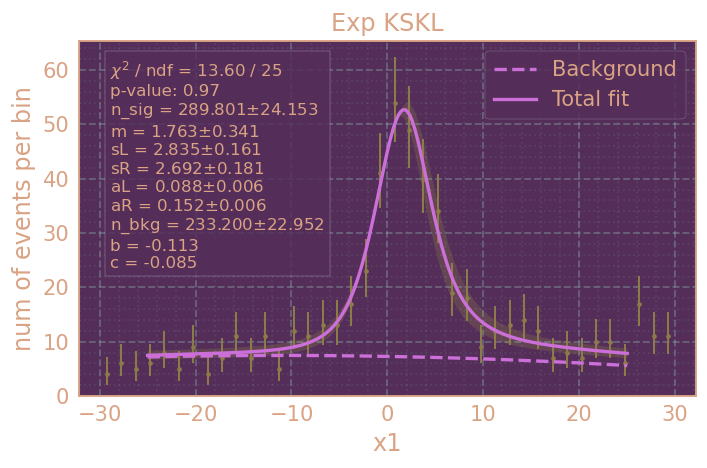

In [442]:
hist_rng, bins = (-30, 30), 40
f2.plot(hist_rng, bins=bins, title='Exp KSKL', xtitle='x1', ytitle='num of events per bin', lw=2, 
        alpha=1, plot_bkg=True, fit_color='#CC6FD9', data_color='#8C7B48', bbox_color='#542D59', fill_errors=True);

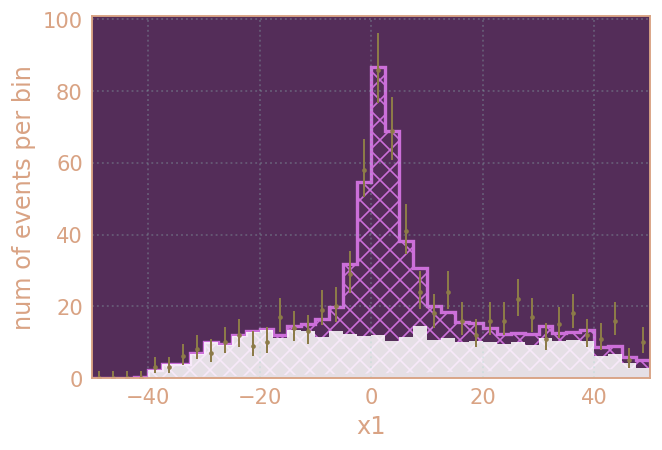

In [443]:
bins, range = 40, (-50, 50)
dm = f2.m.values['m'] - fmc.m.values['m']
bkg, sig = df_mltq.query('finalstate_id!=8').x1, df_mcq.x1 + dm
bkg_weight = f2.m.values['n_bkg']/((bkg < fit_range_bkg[1]) & (bkg > fit_range_bkg[0])).sum()
sig_weight = f2.m.values['n_sig']/((sig < fit_range_bkg[1]) & (sig > fit_range_bkg[0])).sum()
bkg_hist, _, _ = plt.hist(bkg, weights=np.ones_like(bkg)*bkg_weight, bins=bins, range=range, alpha=0.85, color='white');
plt.hist(sig, weights=np.ones_like(sig)*sig_weight, bins=bins, range=range, histtype='step', lw=2, hatch=r'\\//', bottom=bkg_hist, zorder=0, color='#CC6FD9');
pys.hep_histo(dfq.x1, range=range, bins=bins)
plt.xlabel('x1')
plt.ylabel('num of events per bin')
plt.xlim(range);

#### triggers

In [444]:
temp = dfq.query(f'(x1>{fit_range_bkg[0]})&(x1<{fit_range_bkg[1]})').trigbits
trig_eff = kskl.trigger_efficiency(temp)
trig_eff

{'T': (0.940809968847352, 0.013150652555046468),
 'C': (0.5956607495069034, 0.021774118720865772),
 'TC': (0.9760671471670753, 0.005471286715130644)}

#### write fit

In [445]:
fit_pars, fit_errs = f2.get_params(), f2.get_sigmas(exclude=[])
fit_pars_mc, fit_errs_mc = fmc.get_params(), fmc.get_sigmas(exclude=[])

res_dict = dict(
    elabel=elabel, n_sig=fit_pars['n_sig'], n_sig_err=fit_errs['n_sig'],
    n_bkg=fit_pars['n_bkg'], n_bkg_err=fit_errs['n_bkg'],
    n_sig_mc=fit_pars_mc['n_sig'], n_sig_mc_err=fit_errs_mc['n_sig'],
    trig_eff=trig_eff['TC'][0], trig_eff_err=trig_eff['TC'][1],
    range_min=fit_range_bkg[0], range_max=fit_range_bkg[1],
)

In [446]:
fit_df = fit_df.append(res_dict, ignore_index=True)
fit_df.tail()

,elabel,n_sig,n_sig_err,n_bkg,n_bkg_err,n_sig_mc,n_sig_mc_err,trig_eff,trig_eff_err,range_min,range_max
21,762.5_12338,87.754666,14.361584,157.280403,16.605620,3031.018654,56.144712,0.974063,0.007070,-25.0,25.0
22,662.5_12532,61.722817,15.425793,211.272611,20.880548,1627.827102,40.344193,0.972234,0.006296,-25.0,25.0
23,637.5_12693,110.346739,17.282186,202.670153,19.772332,1817.194067,42.630835,0.943753,0.010486,-25.0,25.0
24,612.5_12811,201.863694,22.976291,242.136313,23.836137,2039.009595,45.025171,0.950428,0.008479,-25.0,25.0
25,587.5_12894,289.800865,24.152698,233.200372,22.951501,2281.983822,48.136318,0.976067,0.005471,-25.0,25.0


In [450]:
# fit_df.to_csv('../csv/HIGH/results/fit_result.csv', index=False)

### MC $\gamma$ energy

In [451]:
from pylib.regeff import RegEff
df_resunimc = pd.DataFrame()

In [452]:
SEASON = 'HIGH11'
df_total_info = kskl.season_csv_table(SEASON)
df_signal = pd.read_csv(f'../csv/{SEASON}/results/fit_result.csv')
df_signal.head()

,elabel,n_sig,n_sig_err,n_bkg,n_bkg_err,n_sig_mc,n_sig_mc_err,trig_eff,trig_eff_err,range_min,range_max
0,575_9288,279.931734,24.713274,195.134253,22.930275,2421.028500,47.149959,0.831342,0.016329,-25.0,25.0
1,600_9407,137.161965,19.980894,225.838018,22.082516,2053.172386,44.936936,0.718536,0.024464,-25.0,25.0
2,625_9475,58.473048,15.990277,207.558189,20.117835,1832.994854,42.813422,0.836530,0.020461,-25.0,25.0
3,650_9703,67.809672,16.250213,206.178847,20.056346,1660.020902,40.692529,0.882753,0.016219,-25.0,25.0
4,725_10052,31.979123,12.264439,177.030385,17.187149,1525.975949,37.064436,0.974230,0.006179,-25.0,25.0


In [453]:
df_total_info = pd.merge(df_total_info, df_signal[['elabel', 'range_min', 'range_max']], on='elabel')

In [454]:
def process_uniform(df_cuts: list, df_totals: list, bins=80):
    
    rng = (df_totals[0].sim_gamma_energy.min(), df_totals[0].sim_gamma_energy.max())
    dat0, dat1 = None, None
    for df_cut, df_total in zip(df_cuts, df_totals):
        dat0_, bins = np.histogram(df_total.sim_gamma_energy, bins=bins, range=rng)
        dat1_, bins = np.histogram(df_cut.sim_gamma_energy, bins=bins, range=rng)
        dat0 = dat0_ if dat0 is None else dat0 + dat0_
        dat1 = dat1_ if dat1 is None else dat1 + dat1_
    
    values = (dat1+1)/(dat0+2)
    errors = np.sqrt( (dat1+1)*(dat1+2)/(dat0+2)/(dat0+3) - ((dat1+1)/(dat0+2))**2 )
    return (values, errors, (bins[:-1]+bins[1:])/2)

In [455]:
it = df_total_info.iterrows()

In [586]:
idx, row = next(it)
row

StopIteration: 

In [587]:
tr_ph_mcuni = kskl.open_tree(row['mc_tree_kskl_uniform'])
df_radph0 = kskl.simphoton_energy_df(tr_ph_mcuni)


df_mcuni = kskl.selection_df(tr_ph_mcuni, finalstate_id=True, radiative_photons=True)
df_mcuni = point_cut(df_mcuni, row['emeas'])
df_mcuni = df_mcuni.query(f'(x1<{row["range_max"]})&(x1>{row["range_min"]})')

In [588]:
tr_ph_mc = kskl.open_tree(row['mc_tree_kskl_mcgpj'])
df_radph0_1 = kskl.simphoton_energy_df(tr_ph_mc)

df_mc_1 = kskl.selection_df(tr_ph_mc, finalstate_id=True, radiative_photons=True)
df_mc_1 = point_cut(df_mc_1, row['emeas'])
df_mc_1 = df_mc_1.query(f'(x1<{row["range_max"]})&(x1>{row["range_min"]})')

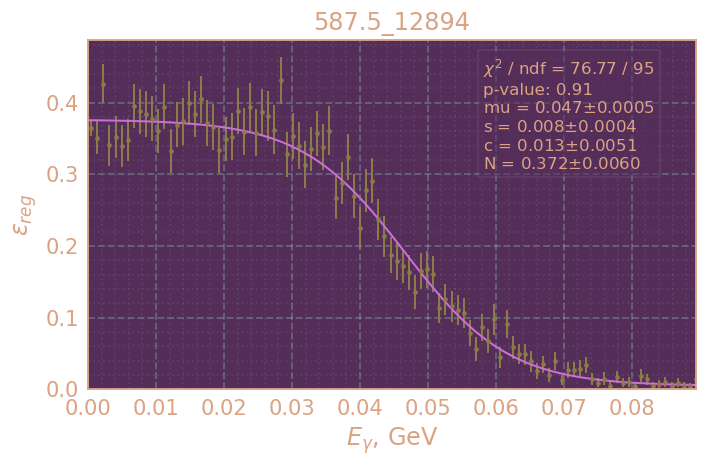

In [589]:
dat = process_uniform([df_mcuni, df_mc_1], [df_radph0, df_radph0_1], bins=100)
fit_res = RegEff.fit_data(dat[0], dat[1], dat[2], mu0=0.05, s0=1/90, name=row['elabel'], fit_color='#CC6FD9', data_color='#8C7B48', bbox_color='#542D59')
fit_res = fit_res.reset_index().rename({'index': 'elabel'}, axis=1)
plt.tight_layout()
# plt.savefig(f'images/regeff17/{row["elabel"]}.png', dpi=120)

In [585]:
df_resunimc = df_resunimc.append(fit_res, ignore_index=True)
df_resunimc.tail()

,elabel,mu,s,c,N,mu_err,s_err,c_err,N_err,eff0,eff0_err
21,762.5_12338,0.092900,0.023126,0.015472,0.354373,0.001913,0.001242,0.003448,0.007145,0.353588,0.007532
22,662.5_12532,0.069691,0.014167,0.018489,0.367373,0.001092,0.000763,0.004074,0.007084,0.371501,0.008163
23,637.5_12693,0.062416,0.013423,0.015088,0.360578,0.001046,0.000804,0.005102,0.007617,0.362603,0.008819
24,612.5_12811,0.055876,0.010038,0.015016,0.367762,0.000729,0.000539,0.004707,0.006399,0.371884,0.007892
25,587.5_12894,0.046671,0.007608,0.012626,0.371503,0.000535,0.000406,0.005056,0.006011,0.375391,0.007758


In [590]:
# df_resunimc.to_csv('../csv/HIGH/results/uniform_mc_result.csv', index=False)

### Radcors

In [591]:
from pylib.radcors import RadCor
from pylib.regeff import RegEff

In [592]:
SEASON = 'HIGH11'

df_total_info = kskl.season_csv_table(SEASON).set_index('elabel')
df_signal = pd.read_csv(f'../csv/{SEASON}/results/fit_result.csv').set_index('elabel')
df_reg_eff = pd.read_csv(f'../csv/{SEASON}/results/uniform_mc_result.csv').set_index('elabel')

df_total_info = pd.concat([df_total_info, df_signal, df_reg_eff], axis=1, join='inner').reset_index()

In [594]:
df_fit = pd.read_csv('../data/other/kskl_cs.csv', index_col=0)
df_radcors = pd.DataFrame()
r = RadCor(df_fit.emeas*0.5e3, df_fit.cs_born)

for index, j in df_total_info.iterrows():
    elabel, emeas = j['elabel'], j['emeas']
    rad, rad_err = r.F_Radcor(j['emeas'], j[['mu', 's', 'c', 'N']])/RegEff.sigFunc(0, *j[['mu', 's', 'c', 'N']])
    radcor_row = dict(elabel=elabel, emeas=emeas, radcor=rad, radcor_err=rad_err)
    df_radcors = df_radcors.append(radcor_row, ignore_index=True)
    
# df_radcors.to_csv('../csv/HIGH/results/radcors_result.csv', index=False)

### Plot CS

In [595]:
def cs_season(SEASON: str):
    df_total_info = kskl.season_csv_table(SEASON).set_index('elabel')
    df_signal = pd.read_csv(f'../csv/{SEASON}/results/fit_result.csv').set_index('elabel')
    df_reg_eff = pd.read_csv(f'../csv/{SEASON}/results/uniform_mc_result.csv').set_index('elabel')
    df_radcors = pd.read_csv(f'../csv/{SEASON}/results/radcors_result.csv').set_index('elabel')

    df_total_info = pd.concat([df_total_info, df_signal, df_reg_eff, df_radcors], axis=1, join='inner').reset_index()
    df_total_info = df_total_info.loc[:,~df_total_info.columns.duplicated()]
    
    cs = df_total_info['n_sig']/df_total_info['lum_exp']/df_total_info['trig_eff']/df_total_info['eff0']/df_total_info['radcor']
    cs_err = cs*(df_total_info['n_sig_err']/df_total_info['n_sig'])
    return {'emeas': df_total_info.emeas, 'cs': cs, 'cs_err': cs_err}

In [597]:
cs_17 = cs_season('HIGH17')
cs_19 = cs_season('HIGH19')
cs_12 = cs_season('HIGH12')
cs_11 = cs_season('HIGH11')

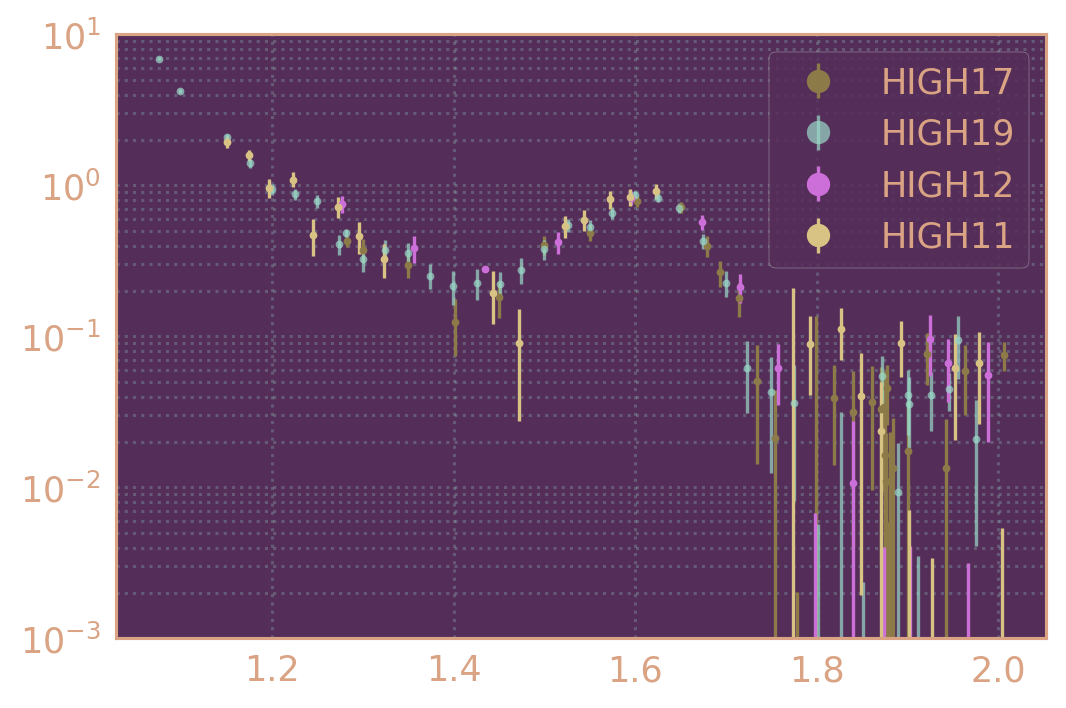

In [600]:
plt.figure(dpi=200)
plt.errorbar(cs_17['emeas']*2e-3, cs_17['cs'], yerr=cs_17['cs_err'], fmt='.', label='HIGH17')
plt.errorbar(cs_19['emeas']*2e-3, cs_19['cs'], yerr=cs_19['cs_err'], fmt='.', alpha=0.7, label='HIGH19')
plt.errorbar(cs_12['emeas']*2e-3, cs_12['cs'], yerr=cs_12['cs_err'], fmt='.', label='HIGH12')
plt.errorbar(cs_11['emeas']*2e-3, cs_11['cs'], yerr=cs_11['cs_err'], fmt='.', label='HIGH11')
plt.ylim(1e-3, 10)
plt.legend()
plt.yscale('log')